<a href="https://colab.research.google.com/github/leo0622nycu/Essay/blob/main/ARIMA%2BMLP_Nvidia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
import pandas as pd
import numpy as np
import os
drive.mount('/content/drive')

Monthly_Revenue = pd.read_csv('/content/drive/MyDrive/CSV/Historical_Monthly_Revenue_November_2.csv')
ARIMA_TRAIN = pd.read_csv('/content/drive/MyDrive/CSV/ARIMA_TRAIN2.csv')
ARIMA_TEST = pd.read_csv('/content/drive/MyDrive/CSV/ARIMA_TEST2.csv')
residuals_all = pd.read_csv('/content/drive/MyDrive/CSV/residuals_all2.csv')
Nvidia = pd.read_csv('/content/drive/MyDrive/CSV/Nvidia.csv')

Mounted at /content/drive


In [471]:
print(ARIMA_TRAIN.head())
print(ARIMA_TEST.head())
print(residuals_all)

Nvidia['time'] = pd.to_datetime(Nvidia['time'], format='%Y%m')
print(Nvidia)

         time      revenue  predicted_mean
0  2014-01-01  148215172.0    1.818454e+08
1  2014-04-01  183020484.0    1.076416e+08
2  2014-07-01  209049734.0    2.039136e+08
3  2014-10-01  222521075.0    2.321504e+08
4  2015-01-01  222034144.0    1.916797e+08
         time      revenue  predicted_mean
0  2022-10-01  625531868.0    6.326281e+08
1  2023-01-01  508632973.0    6.091950e+08
2  2023-04-01  480841254.0    5.028711e+08
3  2023-07-01  546732758.0    5.042027e+08
4  2023-10-01  625528856.0    5.584830e+08
    Unnamed: 0       revenue
0   2014-01-01 -3.363020e+07
1   2014-04-01  7.537887e+07
2   2014-07-01  5.136092e+06
3   2014-10-01 -9.629359e+06
4   2015-01-01  3.035442e+07
5   2015-04-01 -2.612472e+07
6   2015-07-01 -4.026193e+06
7   2015-10-01  7.662667e+06
8   2016-01-01 -3.009178e+06
9   2016-04-01  7.752797e+06
10  2016-07-01  4.365386e+07
11  2016-10-01 -1.112560e+07
12  2017-01-01 -2.700025e+07
13  2017-04-01  1.197989e+06
14  2017-07-01  2.961677e+07
15  2017-10-01  2.16

In [477]:
ARIMA_OUTPUT = pd.concat([ARIMA_TRAIN, ARIMA_TEST], axis=0)
ARIMA_OUTPUT['diff_1'] = ARIMA_OUTPUT['revenue'].diff()
ARIMA_OUTPUT['residuals'] = residuals_all['revenue']


# 更改 diff_1 第一個值
ARIMA_OUTPUT.loc[0, 'diff_1'] = 2409325
ARIMA_OUTPUT = ARIMA_OUTPUT.reset_index(drop=True)
Nvidia = Nvidia.reset_index(drop=True)
ARIMA_OUTPUT['Nvidia'] = Nvidia['Nvidia']
# 將 'time‘ 設為索引，並確認其為 DatetimeIndex
ARIMA_OUTPUT.set_index('time', inplace=True)

# 將索引轉為 Datetime 格式（如果尚未是 datetime）
ARIMA_OUTPUT.index = pd.to_datetime(ARIMA_OUTPUT.index)

# 檢查結果
print(ARIMA_OUTPUT)


                revenue  predicted_mean       diff_1     residuals  Nvidia
time                                                                      
2014-01-01  148215172.0    1.818454e+08    2409325.0 -3.363020e+07    1144
2014-04-01  183020484.0    1.076416e+08   34805312.0  7.537887e+07    1103
2014-07-01  209049734.0    2.039136e+08   26029250.0  5.136092e+06    1103
2014-10-01  222521075.0    2.321504e+08   13471341.0 -9.629359e+06    1225
2015-01-01  222034144.0    1.916797e+08    -486931.0  3.035442e+07    1251
2015-04-01  205439752.0    2.315645e+08  -16594392.0 -2.612472e+07    1151
2015-07-01  212504909.0    2.165311e+08    7065157.0 -4.026193e+06    1153
2015-10-01  203518563.0    1.958559e+08   -8986346.0  7.662667e+06    1305
2016-01-01  203498361.0    2.065075e+08     -20202.0 -3.009178e+06    1401
2016-04-01  221809846.0    2.140570e+08   18311485.0  7.752797e+06    1305
2016-07-01  260405885.0    2.167520e+08   38596039.0  4.365386e+07    1428
2016-10-01  262227252.0  

In [4]:
ARIMA_OUTPUT.to_csv('ARIMA_OUTPUT.csv', header=True)

from google.colab import files
files.download('ARIMA_OUTPUT.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [478]:
# Initialize features and targets
X_grouped = []
Y_grouped = []

# Construct features and targets
for i in range(3, len(ARIMA_OUTPUT)):
    # Lagged diff_1 and residuals (2 lags)
    x_diff_1 = ARIMA_OUTPUT['diff_1'].iloc[i-3:i].values.tolist()
    x_residuals = ARIMA_OUTPUT['residuals'].iloc[i-1:i].values.tolist()
    x_nvidia = ARIMA_OUTPUT['Nvidia'].iloc[i-1:i].values.tolist()

    # Next predicted_mean value (from index i)
    x_predicted_mean = [float(ARIMA_OUTPUT['predicted_mean'].iloc[i])]

    # Organize into grouped structure
    x_grouped = {
        'diff_1': x_diff_1,
        'residuals': x_residuals,
        'predicted_mean': x_predicted_mean,
        'Nvidia': x_nvidia
    }
    X_grouped.append(x_grouped)

    # Next revenue value (from index i)
    y_value = float(ARIMA_OUTPUT['revenue'].iloc[i])
    Y_grouped.append(y_value)

# Confirm the result
print( X_grouped)
print( Y_grouped)



[{'diff_1': [2409325.0, 34805312.0, 26029250.0], 'residuals': [5136091.682745278], 'predicted_mean': [232150434.07834923], 'Nvidia': [1103, 1103]}, {'diff_1': [34805312.0, 26029250.0, 13471341.0], 'residuals': [-9629359.078349233], 'predicted_mean': [191679725.01382557], 'Nvidia': [1103, 1225]}, {'diff_1': [26029250.0, 13471341.0, -486931.0], 'residuals': [30354418.986174464], 'predicted_mean': [231564468.62639612], 'Nvidia': [1225, 1251]}, {'diff_1': [13471341.0, -486931.0, -16594392.0], 'residuals': [-26124716.62639615], 'predicted_mean': [216531101.54420245], 'Nvidia': [1251, 1151]}, {'diff_1': [-486931.0, -16594392.0, 7065157.0], 'residuals': [-4026192.544202447], 'predicted_mean': [195855895.73272675], 'Nvidia': [1151, 1153]}, {'diff_1': [-16594392.0, 7065157.0, -8986346.0], 'residuals': [7662667.267273247], 'predicted_mean': [206507538.89249185], 'Nvidia': [1153, 1305]}, {'diff_1': [7065157.0, -8986346.0, -20202.0], 'residuals': [-3009177.8924918477], 'predicted_mean': [214057049

In [479]:
# 將分群特徵展平成單一數組
X_flattened = []
for x in X_grouped:
    flattened = x['diff_1'] + x['predicted_mean'] +  x['residuals'] +x['Nvidia'] # 展平結構
    X_flattened.append(flattened)


# 轉換為 NumPy 陣列
X_flattened = [x for x in X_flattened if all(val is not None for val in x)]
Y_grouped = [y for y in Y_grouped if y is not None]

# 確認形狀
print(X_flattened)
print(Y_grouped)


[[2409325.0, 34805312.0, 26029250.0, 232150434.07834923, 5136091.682745278, 1103, 1103], [34805312.0, 26029250.0, 13471341.0, 191679725.01382557, -9629359.078349233, 1103, 1225], [26029250.0, 13471341.0, -486931.0, 231564468.62639612, 30354418.986174464, 1225, 1251], [13471341.0, -486931.0, -16594392.0, 216531101.54420245, -26124716.62639615, 1251, 1151], [-486931.0, -16594392.0, 7065157.0, 195855895.73272675, -4026192.544202447, 1151, 1153], [-16594392.0, 7065157.0, -8986346.0, 206507538.89249185, 7662667.267273247, 1153, 1305], [7065157.0, -8986346.0, -20202.0, 214057049.43819723, -3009177.8924918477, 1305, 1401], [-8986346.0, -20202.0, 18311485.0, 216752028.61680284, 7752796.561802775, 1401, 1305], [-20202.0, 18311485.0, 38596039.0, 273352849.259724, 43653856.38319716, 1305, 1428], [18311485.0, 38596039.0, 1821367.0, 260914647.8855796, -11125597.25972402, 1428, 2004], [38596039.0, 1821367.0, -28312852.0, 212657222.57484663, -27000247.885579616, 2004, 2173], [1821367.0, -28312852.0, 

In [480]:
train_X = X_flattened[:32]
train_Y = Y_grouped[:32]

test_X =  X_flattened[32:]
test_Y = Y_grouped[32:]

print(train_X)
print(train_Y)
print(test_X)
print(test_Y)

[[2409325.0, 34805312.0, 26029250.0, 232150434.07834923, 5136091.682745278, 1103, 1103], [34805312.0, 26029250.0, 13471341.0, 191679725.01382557, -9629359.078349233, 1103, 1225], [26029250.0, 13471341.0, -486931.0, 231564468.62639612, 30354418.986174464, 1225, 1251], [13471341.0, -486931.0, -16594392.0, 216531101.54420245, -26124716.62639615, 1251, 1151], [-486931.0, -16594392.0, 7065157.0, 195855895.73272675, -4026192.544202447, 1151, 1153], [-16594392.0, 7065157.0, -8986346.0, 206507538.89249185, 7662667.267273247, 1153, 1305], [7065157.0, -8986346.0, -20202.0, 214057049.43819723, -3009177.8924918477, 1305, 1401], [-8986346.0, -20202.0, 18311485.0, 216752028.61680284, 7752796.561802775, 1401, 1305], [-20202.0, 18311485.0, 38596039.0, 273352849.259724, 43653856.38319716, 1305, 1428], [18311485.0, 38596039.0, 1821367.0, 260914647.8855796, -11125597.25972402, 1428, 2004], [38596039.0, 1821367.0, -28312852.0, 212657222.57484663, -27000247.885579616, 2004, 2173], [1821367.0, -28312852.0, 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


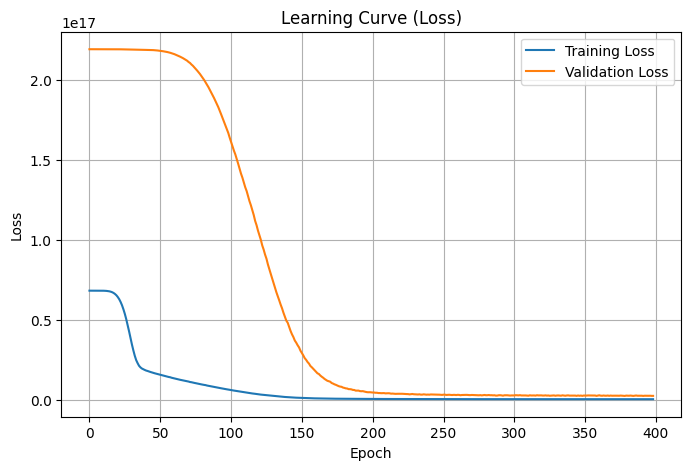

In [521]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# 假設已經有 train_X, train_Y, test_X, test_Y

# 1. 把特徵標準化
scaler = StandardScaler()
train_X_scaled = scaler.fit_transform(train_X)
test_X_scaled = scaler.transform(test_X)

# 2. 構建 MLP 模型
model = Sequential()
model.add(Dense(128, activation='relu',input_dim=train_X_scaled.shape[1]))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1))  # 單一輸出 (revenue)
model.compile(optimizer='adam', loss='mse', metrics=['mape'])

# 3. 定義回調函數
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

# 4. 訓練模型
train_Y = np.array(train_Y)
history = model.fit(
    train_X_scaled, train_Y,
    validation_split=0.2,  # 使用 20% 的訓練數據進行驗證
    epochs=2000,
    batch_size=1,
    callbacks=[early_stopping],
    verbose=0
)

import matplotlib.pyplot as plt

epochs_range = range(len(history.history['loss']))

plt.figure(figsize=(8, 5))
plt.plot(epochs_range, history.history['loss'], label='Training Loss')
plt.plot(epochs_range, history.history['val_loss'], label='Validation Loss')
plt.title('Learning Curve (Loss)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()




1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


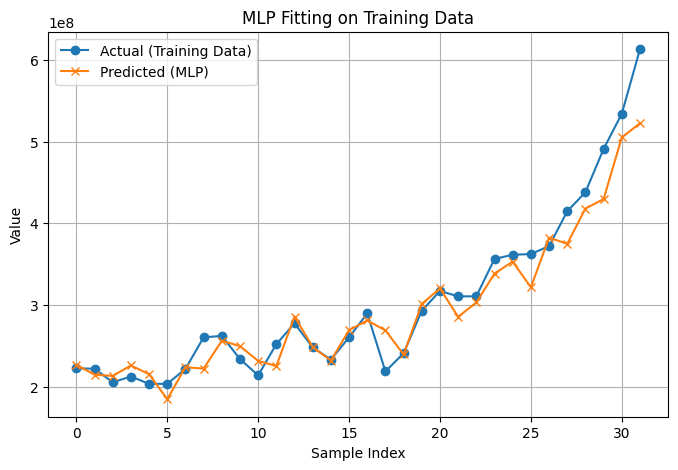

In [522]:
import matplotlib.pyplot as plt

# 假設 X, y 是你的訓練集 (由 split_sequence() 產生)
# 訓練完成後：
y_pred_train = model.predict(train_X_scaled)  # 模型在訓練集上的預測

plt.figure(figsize=(8, 5))


plt.plot(range(len(train_Y)), train_Y, marker='o', label='Actual (Training Data)')


y_pred_train_1d = y_pred_train.flatten()
plt.plot(range(len(y_pred_train_1d)), y_pred_train_1d, marker='x', label='Predicted (MLP)')

plt.title('MLP Fitting on Training Data')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.grid(True)
plt.legend()
plt.show()



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


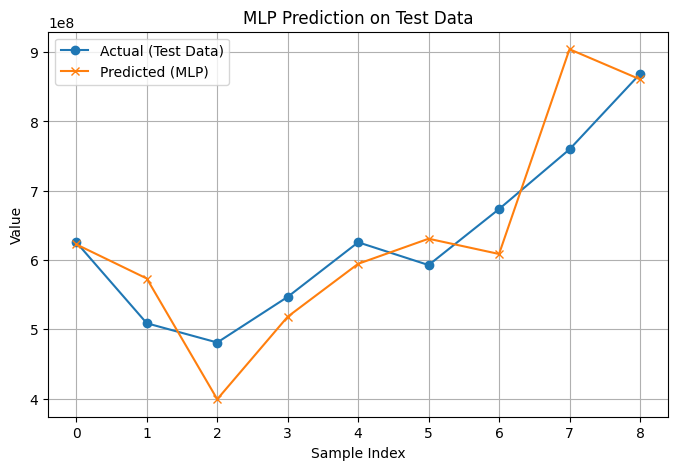

In [523]:
y_pred_test = model.predict(test_X_scaled)

plt.figure(figsize=(8, 5))


plt.plot(range(len(test_Y)), test_Y, marker='o', label='Actual (Test Data)')


y_pred_test_1d = y_pred_test.flatten()
plt.plot(range(len(y_pred_test_1d)), y_pred_test_1d, marker='x', label='Predicted (MLP)')

plt.title('MLP Prediction on Test Data')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.grid(True)
plt.legend()
plt.show()

In [524]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np



# 1. 計算 RMSE
rmse = np.sqrt(mean_squared_error(test_Y, y_pred_test_1d))

# 2. 計算 MAE
mae = mean_absolute_error(test_Y, y_pred_test_1d)

# 3. 計算 MAPE
mape = np.mean(np.abs((test_Y - y_pred_test_1d) / test_Y)) * 100

# 4. 輸出結果
print(f"RMSE : {rmse:.2f}")
print(f"MAE : {mae:.2f}")
print(f"MAPE : {mape:.2f}%")

RMSE : 66061815.86
MAE : 51591984.00
MAPE : 8.49%
